# Cats vs Dogs - Image Classification Using CNN

Este trabalho tem como sua base o terceiro capítulo do livro [Neural Network Projects with Python](https://www.amazon.com.br/Neural-Network-Projects-Python-James/dp/1789138906). Neste capítulo o autor usa o James Loy mostra como usar a biblioteca [Keras](https://keras.io/) para criar uma Convolution Neural Network com intuito de classificar se um animal é um gato ou um cachorro do dataset [Cats and Dogs](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Neste notebook você podera encontrar algumas diferenças do encontrado no livro ou mesmo no [repósitorio](https://github.com/PacktPublishing/Neural-Network-Projects-with-Python/tree/master/Chapter04) do livro do autor, como por exemplo a parte de análise exploratória um pouco mais extensa, feature engineering e otimização da rede neural criada para resolver o problema de classificação do dataset.

In [1]:
# Manipulação de Dados
import numpy as np
import pandas as pd
import random

# Visualização de Dados
import matplotlib.pyplot as plt

# Sistema Operacional
import os
import shutil
import piexif

# Preprocessing
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Obtendo a lista com os nomes dos arquivos
_, _, cat_images = next(os.walk('Data/catsanddogs/PetImages/Cat'))

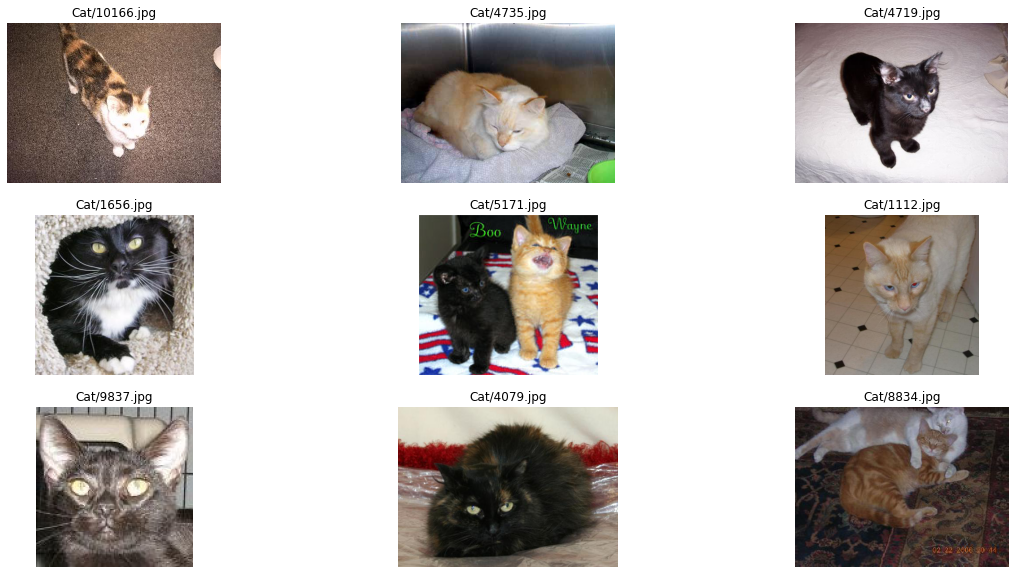

In [3]:
# Plot com 9 imagens de gatos
fig, ax = plt.subplots(3,3, figsize=(20,10))

# Selecionando as imagens aleatóriamente
for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread('Data/catsanddogs/PetImages/Cat/'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Cat/'+img)

plt.show()

In [4]:
# Obtendo a lista com os nomes dos arquivos
_, _, dog_images = next(os.walk('Data/catsanddogs/PetImages/Dog'))

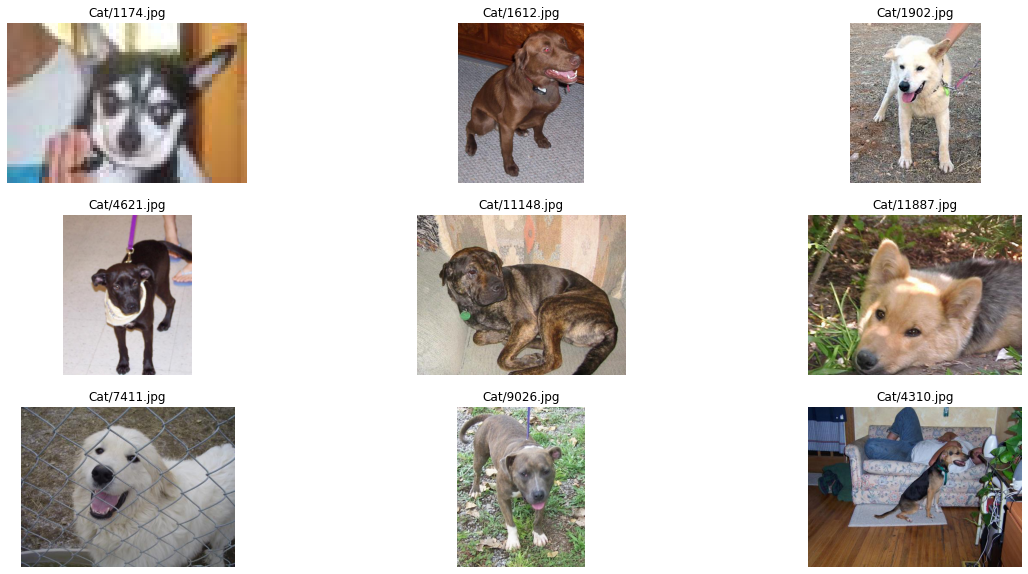

In [5]:
# Plot com 9 imagens de cachorros
fig, ax = plt.subplots(3,3, figsize=(20,10))

# Selecionando as imagens aleatóriamente
for idx, img in enumerate(random.sample(dog_images, 9)):
    img_read = plt.imread('Data/catsanddogs/PetImages/Dog/'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Cat/'+img)

plt.show()

In [6]:
# Função para dividir em treino e teste
def train_test_split(src_folder, train_size = 0.8):
    # Certifique-se de remover todas as pastas existentes e começar de uma forma limpa
    shutil.rmtree(src_folder+'Train/Cat/', ignore_errors=True)
    shutil.rmtree(src_folder+'Train/Dog/', ignore_errors=True)
    shutil.rmtree(src_folder+'Test/Cat/', ignore_errors=True)
    shutil.rmtree(src_folder+'Test/Dog/', ignore_errors=True)

    # Agora, crie novas pastas vazias de trem e teste
    os.makedirs(src_folder+'Train/Cat/')
    os.makedirs(src_folder+'Train/Dog/')
    os.makedirs(src_folder+'Test/Cat/')
    os.makedirs(src_folder+'Test/Dog/')

    # Obter o número de imagens de cães e gatos
    _, _, cat_images = next(os.walk(src_folder+'Cat/'))
    files_to_be_removed = ['Thumbs.db', '666.jpg', '835.jpg']
    for file in files_to_be_removed:
        cat_images.remove(file)
    num_cat_images = len(cat_images)
    num_cat_images_train = int(train_size * num_cat_images)
    num_cat_images_test = num_cat_images - num_cat_images_train

    _, _, dog_images = next(os.walk(src_folder+'Dog/'))
    files_to_be_removed = ['Thumbs.db', '11702.jpg']
    for file in files_to_be_removed:
        dog_images.remove(file)
    num_dog_images = len(dog_images)
    num_dog_images_train = int(train_size * num_dog_images)
    num_dog_images_test = num_dog_images - num_dog_images_train

    # Atribuir imagens aleatoriamente para treinar e testar
    cat_train_images = random.sample(cat_images, num_cat_images_train)
    for img in cat_train_images:
        shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Train/Cat/')
    cat_test_images  = [img for img in cat_images if img not in cat_train_images]
    for img in cat_test_images:
        shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Test/Cat/')

    dog_train_images = random.sample(dog_images, num_dog_images_train)
    for img in dog_train_images:
        shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Train/Dog/')
    dog_test_images  = [img for img in dog_images if img not in dog_train_images]
    for img in dog_test_images:
        shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Test/Dog/')

    # remover dados exif corrompidos do conjunto de dados
    remove_exif_data(src_folder+'Train/')
    remove_exif_data(src_folder+'Test/')

# função auxiliar para remover dados exif corrompidos do conjunto de dados da Microsoft
def remove_exif_data(src_folder):
    _, _, cat_images = next(os.walk(src_folder+'Cat/'))
    for img in cat_images:
        try:
            piexif.remove(src_folder+'Cat/'+img)
        except:
            pass

    _, _, dog_images = next(os.walk(src_folder+'Dog/'))
    for img in dog_images:
        try:
            piexif.remove(src_folder+'Dog/'+img)
        except:
            pass

In [7]:
# Divisão de treino e teste
src_folder = 'Data/catsanddogs/PetImages/'
train_test_split(src_folder)

In [8]:
# Image Augmentation
image_generator = ImageDataGenerator(rotation_range = 30,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

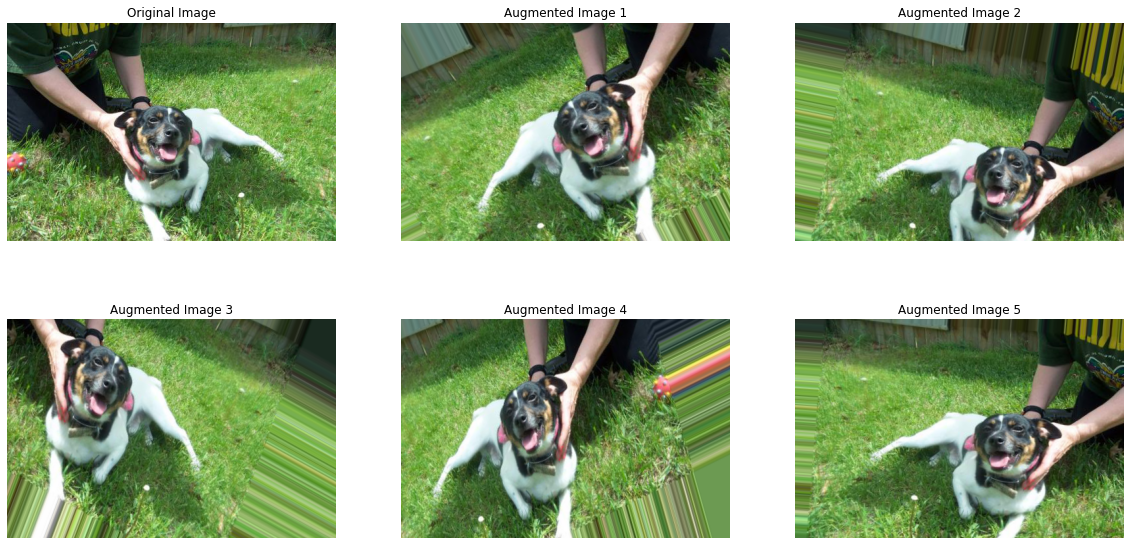

In [9]:
# Checando a Image Augmentation
fig, ax = plt.subplots(2,3, figsize=(20,10))
all_images = []

_, _, dog_images = next(os.walk('Data/catsanddogs/PetImages/Train/Dog/'))
random_img = random.sample(dog_images, 1)[0]
random_img = plt.imread('Data/catsanddogs/PetImages/Train/Dog/'+random_img)
all_images.append(random_img)

random_img = random_img.reshape((1,) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype('uint8'))

for idx, img in enumerate(all_images):
    ax[int(idx/3), idx%3].imshow(img)
    ax[int(idx/3), idx%3].axis('off')
    if idx == 0:
        ax[int(idx/3), idx%3].set_title('Original Image')
    else:
        ax[int(idx/3), idx%3].set_title('Augmented Image {}'.format(idx))

plt.show()